# Multi-class Classification

In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize handwritten digits. 

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. 

Before we begin with the exercises, we need to import all libraries required for this programming exercise. We will be using numpy for all arrays and matrix operations, matplotlib for plotting, and scipy for scientific and numerical computation functions and tools. 

In [2]:
import scipy.io
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# This is just a helper function to display handwritten digits from MNITS dataset
def displayData(X, example_width=None):
    """ %DISPLAYDATA Display 2D data in a nice grid
   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
   stored in X in a nice grid. 
    """
    # Compute rows, cols
    m, n = X.shape

    # Set example_width automatically if not passed in
    if example_width is None:
        example_width = int(np.round(np.sqrt(n)))

    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                    cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

## Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you have learned can be used for this classification task.

In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

### Dataset

You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits (This is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist) handwritten digit dataset). The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. We use the `.mat` format here because this is the dataset provided in the MATLAB version of this assignment. Fortunately, python provides mechanisms to load MATLAB native format using the `loadmat` function within the `scipy.io` module. This function returns a python dictionary with keys containing the variable names within the `.mat` file. 

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix `X` where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector `y` that contains labels for the training set. 
We start the exercise by first loading the dataset. Execute the cell below, you do not need to write any code here.

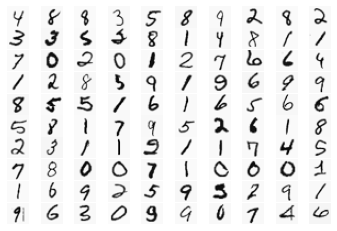

In [4]:

input_layer_size  = 400  # 20x20 Input Images of Digits
num_labels = 10          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

""" =========== Part 1: Loading and Visualizing Data =============
  We start the exercise by first loading and visualizing the dataset. 
  You will be working with a dataset that contains handwritten digits.
"""

# Load Training Data

mat = scipy.io.loadmat('ex3data1.mat') # training data 
X = mat['X']
y = mat['y']
m = len(X)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

### Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any `for` loops. You can use your code in the previous exercise as a starting point for this exercise. 

To test your vectorized logistic regression, we will use custom data as defined in the following cell.

#### Vectorizing the cost function 

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Then, by computing the matrix product $X\theta$, we have: 

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.

#### Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

where

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} 
$$


Note that $x^{(i)}$ is a vector, while $h_\theta\left(x^{(i)}\right) - y^{(i)}$  is a scalar (single number).
To understand the last step of the derivation, let $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ and
observe that:

$$ 
\sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

where the values $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

The expression above allows us to compute all the partial derivatives
without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. 

#### Vectorizing regularized logistic regression

After you have implemented vectorization for logistic regression, you will now
add regularization to the cost function. Recall that for regularized logistic
regression, the cost function is defined as

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not be regularizing $\theta_0$ which is used for the bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$

Now modify your code in lrCostFunction to account for regularization. Once again, you should not put any loops into your code.

**Debugging Tip:** Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the `shape` property of `numpy` arrays. For example, given a data matrix $X$ of size $100 \times 20$ (100 examples, 20 features) and $\theta$, a vector with size $20$, you can observe that `np.dot(X, theta)` is a valid multiplication operation, while `np.dot(theta, X)` is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.

**python/numpy Tip:** When implementing the vectorization for regularized logistic regression, you might often want to only sum and update certain elements of $\theta$. In `numpy`, you can index into the matrices to access and update only certain elements. For example, A[:, 3:5]
= B[:, 1:3] will replaces the columns with index 3 to 5 of A with the columns with index 1 to 3 from B. To select columns (or rows) until the end of the matrix, you can leave the right hand side of the colon blank. For example, A[:, 2:] will only return elements from the $3^{rd}$ to last columns of $A$. If you leave the left hand size of the colon blank, you will select elements from the beginning of the matrix. For example, A[:, :2] selects the first two columns, and is equivalent to A[:, 0:2]. In addition, you can use negative indices to index arrays from the end. Thus, A[:, :-1] selects all columns of A except the last column, and A[:, -5:] selects the $5^{th}$ column from the end to the last column. Thus, you could use this together with the sum and power ($^{**}$) operations to compute the sum of only the elements you are interested in (e.g., `np.sum(z[1:]**2)`). In the starter code, `lrCostFunction`, we have also provided hints on yet another possible method computing the regularized gradient.


In [5]:

""" ============ Part 2: Vectorize Logistic Regression ============
In this part of the exercise, you will reuse your logistic regression
code from the last exercise. You task here is to make sure that your
regularized logistic regression implementation is vectorized. After
that, you will implement one-vs-all classification for the handwritten
digit dataset.
"""

def sigmoid(z):
    """
    return the sigmoid of z
    """
    return 1/ (1 + np.exp(-z))

def lrCostFunction(theta, X, y, Lambda):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. to the parameters.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is the number of features including any intercept.  
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and n is the number of features (including intercept).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta
    
    Hint 1
    ------
    The computation of the cost function and gradients can be efficiently
    vectorized. For example, consider the computation
    
        sigmoid(X @ theta)
    
    Each row of the resulting matrix will contain the value of the prediction
    for that example. You can make use of this to vectorize the cost function
    and gradient computations. 
    
    Hint 2
    ------
    When computing the gradient of the regularized cost function, there are
    many possible vectorized solutions, but one solution looks like:
    
        grad = (unregularized gradient for logistic regression)
        temp = theta 
        temp[0] = 0   # because we don't add anything for j = 0
        grad = grad + YOUR_CODE_HERE (using the temp variable)
    
    """
    #Initialize some useful values
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    
    m=len(y)
    predictions = sigmoid(X @ theta).reshape(-1,1)
    error = (-1*y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # compute gradient
    j_0= 1/m * (X.transpose() @ (predictions - y))[0]
    j_1 = 1/m * (X.transpose() @ (predictions - y))[1:] + ((Lambda/m)* theta[1:]).reshape(-1,1)
    
    grad= np.vstack((j_0[:,np.newaxis],j_1))
    return regCost[0], grad

In [6]:
theta_t = np.array([-2,-1,1,2]).reshape(4,1)
X_t =np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T
X_t = np.hstack((np.ones((5,1)), X_t))
y_t = np.array([1,0,1,0,1]).reshape(5,1)
J, grad = lrCostFunction(theta_t, X_t, y_t, 3)
print("Cost:",J,"Expected cost: 2.534819")
print("Gradients:\n",grad,"\nExpected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")

Cost: 2.534819396109744 Expected cost: 2.534819
Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


In [7]:
def oneVsAll(X, y, num_labels, Lambda):
 """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features. Note that we 
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    
    Instructions
    ------------
    You should complete the following code to train `num_labels`
    logistic regression classifiers with regularization parameter `lambda_`. 
    
    Hint
    ----
    You can use y == c to obtain a vector of 1's and 0's that tell you
    whether the ground truth is true/false for this class.
    
    Note
    ----
    For this assignment, we recommend using `scipy.optimize.minimize(method='CG')`
    to optimize the cost function. It is okay to use a for-loop 
    (`for c in range(num_labels):`) to loop over the different classes.
    
    Example Code
    ------------
    
        # Set Initial theta
        initial_theta = np.zeros(n + 1)
      
        # Set options for minimize
        options = {'maxiter': 50}
    
        # Run minimize to obtain the optimal theta. This function will 
        # return a class object where theta is in `res.x` and cost in `res.fun`
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options) 
    """
    m, n = X.shape[0], X.shape[1]
    initial_theta = np.zeros((n+1,1))
    all_theta = []
    all_J=[]
    # add intercept terms
    
    X = np.hstack((np.ones((m,1)),X))
    
    for c in range(1,num_labels+1):
        # Set Initial theta
        initial_theta = np.zeros(n + 1)
      
        # Set options for minimize
        options = {'maxiter': 50}
    
        # Run minimize to obtain the optimal theta. This function will 
        # return a class object where theta is in `res.x` and cost in `res.fun`
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), Lambda), 
                                jac=True, 
                                method='TNC',
                                options=options)
        all_theta.extend(res.x)

    return np.array(all_theta).reshape(num_labels,n+1)

In [8]:
Lambda = 0.1
all_theta = oneVsAll(X, y, num_labels, Lambda)

#### One-vs-all Prediction

After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the “probability” that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, ..., K-1) as the prediction for the input example. You should now complete the code in the function `predictOneVsAll` to use the one-vs-all classifier for making predictions. 

In [9]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.
    
    X : array_like
        Data points to predict their labels. This is a matrix of shape 
        (m x n) where m is number of data points to predict, and n is number 
        of features without the bias term. Note we add the bias term for X in 
        this function. 
    
    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned logistic
    regression parameters (one-vs-all). You should set p to a vector of predictions
    (from 0 to num_labels-1).
    
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index 
    of the max for each row.
    """
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    predictions = X @ all_theta.T
    return np.argmax(predictions,axis=1)+1

Once you are done, call your `predictOneVsAll` function using the learned value of $\theta$. You should see that the training set accuracy is about 95.1% (i.e., it classifies 95.1% of the examples in the training set correctly).

In [10]:
""" ================ Part 3: Predict for One-Vs-All ================
  After ...
"""
pred = predictOneVsAll(all_theta, X)

print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 95.32000000000001 %


## Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier (You could add more features - such as polynomial features - to logistic regression, but that can be very expensive to train).

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters. 

We start by first reloading and visualizing the dataset which contains the MNIST handwritten digits (this is the same as we did in the first part of this exercise, we reload it here to ensure the variables have not been modified). 


### Model representation 

Our neural network is shown in the following figure.

![Neural network](neuralnetwork.png)

It has 3 layers: an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y. 

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by us. These are stored in `ex3weights.mat`. The following cell loads those parameters into  `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [11]:
mat2=scipy.io.loadmat("ex3weights.mat")
Theta1=mat2["Theta1"] # Theta1 has size 25 x 401
Theta2=mat2["Theta2"] # Theta2 has size 10 x 26

def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    return np.argmax(a2,axis=1)+1
    
pred2 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 97.52 %
